Team : Ruila PUSKAS-JUHASZ and Agathe LHOPITEAU

# Challenge SD-TSIA210

In [1]:
%matplotlib inline
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

### Load and investigate the Data

In [2]:
Xtrain = np.loadtxt('xtrain_challenge.csv', delimiter=',', skiprows = 1)
Ytrain = np.loadtxt('ytrain_challenge.csv', delimiter=',', skiprows = 1)
Xtest = np.loadtxt('xtest_challenge.csv', delimiter=',', skiprows = 1)

#Let's check the shape of the training sets
print(Xtrain.shape)
print(Ytrain.shape)

#Using our own training data to test, we used those commands to do our own tests and avoid uploading the file each time.
#X_train, X_test, Y_train, Y_test = train_test_split(Xtrain, Ytrain, test_size = 0.20)
#print(X_train.shape,Y_train.shape)
#print(X_test.shape,Y_test.shape)

(1068504, 37)
(1068504,)


Before processing and testing the data, we visualize it so as to have a better feeling about its distribution.

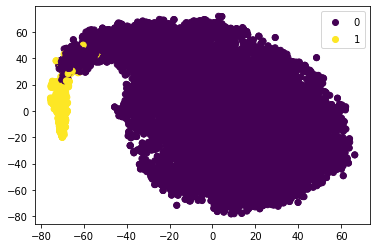

In [3]:
#Let's visualize the first 10.000 inputs of our dataset
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(Xtrain[:10000])

X,Y=[],[]
for i in range(len(X_embedded)) :
    X.append(X_embedded[i][0])
    Y.append(X_embedded[i][1])

#We only print the 10.000 first inputs because it lasts too long to do so on the whole dataset.
scatter=plt.scatter(X, Y, c=Ytrain[:10000])
plt.legend(*scatter.legend_elements())
plt.show()

The distribution of the data is heterogenous, so we can think about separating it into two classes. 
<br> 
After this remark, we are going to scale the data to gain efficiency during the learning processes. 

In [4]:
#Scaling the data for more efficiency during learning processes
Xtrain = preprocessing.scale(Xtrain)
Xtest = preprocessing.scale(Xtest)

## Let's try a few methods


## Deep Neural Network

In [10]:
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense, Activation, Flatten
from keras import optimizers

data = Xtrain
labels = Ytrain
modelDNN = Sequential()
modelDNN.add(Dense(32,activation='softmax',input_dim=37))
modelDNN.add(Dense(1, activation='sigmoid'))

#modelDNN.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=['accuracy'])

from keras.optimizers import SGD
opt = SGD(lr=0.01)
modelDNN.compile(loss = "binary_crossentropy", optimizer = opt, metrics = ['accuracy'])

modelDNN.fit(Xtrain,Ytrain,epochs=10,batch_size=32)
Ypred_dnn = modelDNN.predict(Xtest)
np.reshape(Ypred_dnn,(len(Ypred_dnn,)))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
1068504/1068504 [==============================] - 47s 44us/step - loss: 0.0709 - accuracy: 0.9808
Epoch 2/10
1068504/1068504 [==============================] - 48s 45us/step - loss: 0.0187 - accuracy: 0.9977
Epoch 3/10
1068504/1068504 [==============================] - 47s 44us/step - loss: 0.0126 - accuracy: 0.9979
Epoch 4/10
1068504/1068504 [==============================] - 48s 45us/step - loss: 0.0103 - accuracy: 0.9980
Epoch 5/10
1068504/1068504 [==============================] - 47s 44us/step - loss: 0.0092 - accuracy: 0.9980
Epoch 6/10
1068504/1068504 [==============================] - 47s 44us/step - loss: 0.0085 - accuracy: 0.9980
Epoch 7/10
1068504/1068504 [==============================] - 47s 44us/step - loss: 0.0081 - accuracy: 0.9980
Epoch 8/10
1068504/1068504 [==============================] - 47s 44us/step - loss: 0.0077 - accuracy: 0.9981


array([0.00091311, 0.00150186, 0.00100604, ..., 0.0008471 , 0.00089806,
       0.00097865], dtype=float32)

This method doesn't take too much time (about 10min), and gives a pretty good accarcy. <br>
The output array gives the probability, for each row, to have a label 1. We decide not to change this and to reuse this information later (in the final computation algorithm). The only change we make on this output is to reshape it.

## Random Forest

Before training the random forest algorithm, we are going to tune the parameters, that is,  the number of trees needed for the forest to correctly predict Xtest. To do that, we'll use a Grid Search. <br>
We test three values 50, 100 and 200 because our manual tries showed that the number of tree is between 50 and 200, and that 100 is a presumably good number. Let's verify that this assumption is correct. 

In [12]:
from sklearn.ensemble import RandomForestClassifier

############################# First we apply a grid search to see which parameter is the best######
rfclass = RandomForestClassifier()

#Create a dictionnary of all values we want to test for n_estimators, aka the number of trees
params_rf = {"n_estimators": [50, 100, 200]}

#use gridsearch to test all values for n_estimators
modelRF_gs = GridSearchCV(rfclass, params_rf, cv=5)

# Fit on training data
modelRF_gs.fit(Xtrain, Ytrain)

#save best model
rf_best = modelRF_gs.best_estimator_

#check best n_estimators value
print(modelRF_gs.best_params_)

{'n_estimators': 100}


When we compute the grid search, we get : 
* for 1000 features : 100 trees
* for 10 000 features : 50 trees
* for 100 000 features : 100 trees
* for the whole data set : 100 trees. 

<br> We will thus chose 100 trees for our random forest. 

In [6]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
# Fit on training data
model.fit(Xtrain, Ytrain)

Ypred_forest = model.predict(Xtest)

Using only this random forest, we have a pretty good result : accuracy of 0.998063463898. Moreover, the computing time isn't very long, so this method is pretty efficient and we decide to keep it for our ensemble learning.

## Logistic regression 

We don't need to do any fine-tuning Grid Search for the Logistic Regression classifier. Furthermore, the computing time is quite short so we decide to keep this method as well in our ensemble. 

In [7]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(Xtrain, Ytrain)

/Users/ruilapuskas/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [8]:
Ypred_logreg = logreg.predict(Xtest)

This method provides a pretty good accuracy : 0.9978, and is computed very quickly (less than 5 minutes). We thus decide to keep it for our futur ensemble learning.

## K-nearest neighbours

In [10]:
from sklearn.neighbors import KNeighborsClassifier

############WITHOUT ENSEMBLES###################
#We fix the number of neighbors equal to 100
#clfKNN = KNeighborsClassifier(n_neighbors=100)
#clfKNN = clfKNN.fit(Xtrain, Ytrain)

#We predict the labels 
#Ypred_knn = clfKNN.predict(Xtest)

#Compute the accuracy
#accuracy_score(Ypred_knn, Y_test)


###########WITH ENSEMBLES########################
#create new a knn model
knn = KNeighborsClassifier()

#We want to test 30 different values for each neighbor
params_knn = {'n_neighbors': np.arange(1, 9)}

#use gridsearch to test all values for n_neighbors
knn_gs = GridSearchCV(knn, params_knn, cv=3)

#fit model to training data
knn_gs.fit(Xtrain[:10000], Ytrain[:10000])

#save best model
knn_best = knn_gs.best_estimator_

#check best n_neigbors value
print(knn_gs.best_params_)

#Prepare for submission
#np.savetxt('ytest_knn.csv', Ypred_knn, fmt = '%1.0d', delimiter = ',')

#Prepare for submission
ytest_knn = knn_best.predict(Xtest)
#np.savetxt('ytest_knn.csv', ytest_knn, fmt = '%1.0d', delimiter = ',')

{'n_neighbors': 3}


Knn is very quick for features under 100 000, after it is rather slow. To get free from this long computation of the grid search and of the fit, we will test manually the results given by this code for 1000, 10000, 100 000 features. We see that there is a tendancy: the number of neighbours seems to tend towards 3, so we will keep this parameter in the following cell. 

In [ ]:
####### DO NOT RUN #################
modelKNN = KNeighborsClassifier(3)
modelKNN.fit(Xtrain, Ytrain)
Ypred_knn = modelKNN.predict(Xtest)

When we use our own dataset (with a train_test_split), with the K-nearest neighbours method, we get a computation time of approximately 5 minutes and we get an accuracy of 0.9975245787338384, when we take 3 neighbors. 
<br> However, after running the above cell on the whole dataset, the program is still running after 16 hours! After trying different possibilities (Google Colab, connecting to a school computer) that didn't work because of connectivity problems mainly, we decided to drop this method and focus on the Deep Neural Network, the Random Forest and Logistic Regression and see how we can combine them.

## Gradient Boosting
We try the gradient boosting method in the ensemble to replace the Deep Neural Network, since this method gives the lowest accuracy of all methods taken individually. 
<br>
After testing parameters for gradient boosting, we keep the value 50 for n_estimators, 2 for max_features, and 5 for max_depth. We have to see which learning rate to chose. 

In [9]:
from sklearn.ensemble import GradientBoostingClassifier


#learning rate list
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=50, learning_rate=learning_rate, max_features=2, max_depth=5, random_state=0)
    gb_clf.fit(Xtrain, Ytrain)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(Xtrain, Ytrain)))

Learning rate:  0.05
Accuracy score (training): 0.997
Learning rate:  0.075
Accuracy score (training): 0.998
Learning rate:  0.1
Accuracy score (training): 0.998
Learning rate:  0.25
Accuracy score (training): 0.999
Learning rate:  0.5
Accuracy score (training): 0.998
Learning rate:  0.75
Accuracy score (training): 0.998
Learning rate:  1
Accuracy score (training): 0.997


In [10]:
gb_clf2 = GradientBoostingClassifier(n_estimators=50, learning_rate=0.25, max_features=2, max_depth=5, random_state=0)
gb_clf2.fit(Xtrain, Ytrain)
Ypred_gb = gb_clf2.predict(Xtest)

## Now let's vote for best classifier

We choose to compute a new output Ypred, depending on the different ones we found with the Random Forest, the Neural Network and the Logistic Regression. We decide that if, for a row, at least 2 of those methods give a label 1, then it's a 1 ; otherwise this is a 0. This can be translated by having the sum of the three given labels equal or greater than 2. 
<br>
When submitting this file on the website, we got an accuracy of approximately 0.9970. Since the Neural Network gave the lowest accuracy of all three methods taken individually, we tried to replace the labels given by the Deep Neural Network by other methods, such as an SVM and a Boosted Gradient. However, the SVM took too much time to run. Boosted Gradient gave a better accuracy in the ensemble so we decided to keep the GB in the ensemble. 



In [11]:
Ypred = []
for i in range(len(Ypred_logreg)):
    if Ypred_logreg[i] + Ypred_forest[i] + Ypred_gb[i] >= 2 :
        Ypred.append(1)
    else :
        Ypred.append(0)
Ypred = np.array(Ypred)

#We can then save our file that will be uploaded on the website
np.savetxt('ytest_challenge_LHOPITEAU_PUSKAS.csv', Ypred, fmt = '%1.0d', delimiter = ',')


## Remarks and conclusion
The problem is that the accuracy of *any* ensemble is lower than the accuracy given by random forest alone, which is illogical. Thus we examined our methods to spot an overfitting or underfitting, but it's not the case here. So our interrogation is still up. 